In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, transforms
import pretrainedmodels
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from data import data_reader

Tensor = torch.Tensor
rand_m = np.random.random

In [2]:
MODEL_NAME = 'xception'
if not os.path.exists('weights/'):
    !mkdir weights
if not os.path.exists('weights/{}'.format(MODEL_NAME)):
    !mkdir weights/{MODEL_NAME}

In [3]:
class model_xception(nn.Module):
    def __init__(self, num_class):
        super(model_xception, self).__init__()
        self.xception = pretrainedmodels.models.xception()
        self.avgp = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_class)
    
    def forward(self, x):
        x = self.xception.features(x)
        x = self.avgp(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [4]:
model = model_xception(6).to('cuda')

In [5]:
optim = torch.optim.Adam(model.parameters())
loss_func = torch.nn.CrossEntropyLoss()

In [6]:
from data import data_reader
class args:
    bs = 32
    path = 'train2000/'

x_norm = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])
trm = transforms.Compose([
    transforms.Resize(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    x_norm
])

val_trm = transforms.Compose([
    transforms.Resize(333),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    x_norm
])

dr = data_reader(args, 'train2000/train2000.csv', trm=trm, val_trm=val_trm)

train_loader, test_loader = dr.get_train_loader()

In [7]:
train_loss_rec = []
train_acc_rec = []
test_loss_rec = []
test_acc_rec = []
best_acc = 0
for epoch in range(50):
    epoch_loss = 0
    total, correct = 0, 0
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to('cuda'), y_train.to('cuda')
        optim.zero_grad()
        y_hat = model(X_train)
        loss = loss_func(y_hat, torch.max(y_train, 1)[1])
        loss.backward()
        _, pred = torch.max(y_hat.data, 1)
        optim.step()
        correct += (pred == torch.max(y_train, 1)[1]).sum().item()
        total += X_train.size(0)
        epoch_loss += loss.item() / len(train_loader)
        print('\rEpoch {} | Batch # {} Train Loss {:.5f} '.format(epoch, batch_idx, loss.item()))
    print('\rEpoch {} | Epoch Train Loss {:.5f}'.format(epoch, epoch_loss))
    epoch_acc = correct / total * 100
    print('\nEpoch {} | Epoch Train Acc {:.3f}%'.format(epoch, epoch_acc))
    train_loss_rec.append(epoch_loss)
    train_acc_rec.append(epoch_acc)
    with torch.no_grad():
        test_epoch_loss = 0
        test_total = 0
        test_correct = 0
            
        for batch_idx, (X_val, y_val) in enumerate(test_loader):
            X_val, y_val = X_val.to('cuda'), y_val.to('cuda')
            
            y_hat = model(X_val)
            loss = loss_func(y_hat, torch.max(y_val, 1)[1])
            _, pred = torch.max(y_hat.data, 1)
            test_total += y_val.size(0)
            test_correct += (pred == torch.max(y_val, 1)[1]).sum().item()
            test_epoch_loss += loss.item() / len(test_loader)
             
        test_epoch_acc = test_correct / test_total * 100
        if test_epoch_acc > best_acc:
            best_acc = test_epoch_acc
            torch.save(model.state_dict(), 'weights/' + MODEL_NAME + '/best_params_acc{}.pth'.format(best_acc)) 
        print('Epoch {} | Epoch Val Loss {:.5f}'.format(epoch, test_epoch_loss))
        print('Epoch {} | Epoch Val Acc {:.3f}%'.format(epoch, test_epoch_acc))
            
        test_loss_rec.append(test_epoch_loss)
        test_acc_rec.append(test_epoch_acc)

Epoch 0 | Batch # 0 Train Loss 2.00516 
Epoch 0 | Batch # 1 Train Loss 1.26333 
Epoch 0 | Batch # 2 Train Loss 0.67103 
Epoch 0 | Batch # 3 Train Loss 0.92282 
Epoch 0 | Batch # 4 Train Loss 0.47162 
Epoch 0 | Batch # 5 Train Loss 0.24360 
Epoch 0 | Batch # 6 Train Loss 0.46389 
Epoch 0 | Batch # 7 Train Loss 0.26171 
Epoch 0 | Batch # 8 Train Loss 0.31979 
Epoch 0 | Batch # 9 Train Loss 0.51423 
Epoch 0 | Batch # 10 Train Loss 0.60704 
Epoch 0 | Batch # 11 Train Loss 0.40494 
Epoch 0 | Batch # 12 Train Loss 0.42308 
Epoch 0 | Batch # 13 Train Loss 0.07953 
Epoch 0 | Batch # 14 Train Loss 0.55424 
Epoch 0 | Batch # 15 Train Loss 0.13765 
Epoch 0 | Batch # 16 Train Loss 0.41753 
Epoch 0 | Batch # 17 Train Loss 0.44744 
Epoch 0 | Batch # 18 Train Loss 0.96143 
Epoch 0 | Batch # 19 Train Loss 0.17539 
Epoch 0 | Batch # 20 Train Loss 0.33932 
Epoch 0 | Batch # 21 Train Loss 0.10293 
Epoch 0 | Batch # 22 Train Loss 1.78627 
Epoch 0 | Batch # 23 Train Loss 0.30501 
Epoch 0 | Batch # 24 Train

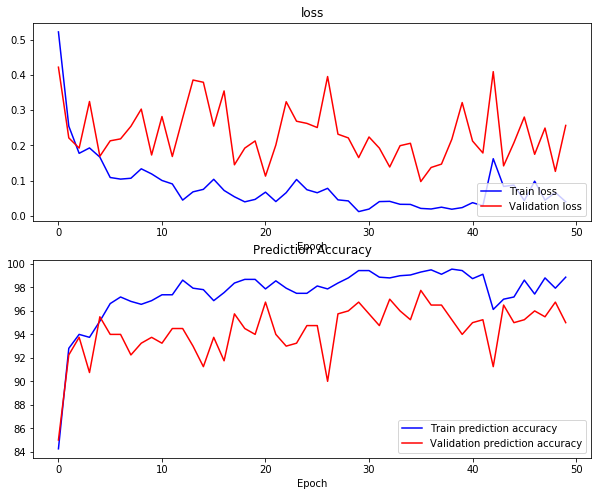

In [8]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.subplot(2,1,1)
plt.plot(train_loss_rec, 'b')
plt.plot(test_loss_rec, 'r')

plt.title('loss')
plt.xlabel('Epoch')

plt.legend(['Train loss', 'Validation loss'], loc=4)

plt.subplot(2,1,2)
plt.plot(train_acc_rec, 'b')
plt.plot(test_acc_rec, 'r')

plt.title('Prediction Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train prediction accuracy' ,'Validation prediction accuracy'], loc=4)
plt.show()